In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
cd drive/'My Drive'/'Data mining'/fake_jobs_classification

/content/drive/My Drive/Data mining/fake_jobs_classification


In [ ]:
import pandas as pd
pd.set_option('display.max_columns', 50)
import numpy as np
import sys
import os
import re
import string
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics as sklm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB, CategoricalNB
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import FunctionTransformer
from time import time
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

# Visualization and feature engineering

In [ ]:
df=pd.read_csv('data/fake_job_postings.csv')
df.sample(5)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
10773,10774,Customer Service Associate,"US, CA, Newark",NaN,NaN,"Novitex Enterprise Solutions, formerly Pitney ...",The Customer Service Associate will be based i...,Requirements:High school diploma or equivalent...,NaN,0,1,0,Full-time,Entry level,High School or equivalent,Computer Hardware,Customer Service,0
12475,12476,Salford I.T Apprenticeship available under NAS...,"GB, , Salford",NaN,NaN,Established on the principles that full time e...,This is fantastic opportunity for someone want...,Government funding is only available for 16-18...,Career prospects,0,1,1,NaN,Not Applicable,High School or equivalent,NaN,Information Technology,0
15910,15911,Sales Proposal Manager,"US, GA, Duluth",Sales/Marketing,NaN,"Horizon Software International, LLC is an indu...",Sales Proposal Writer/ManagerBASIC PURPOSE: T...,JOB SPECIFICATIONS/PERSONAL QUALIFICATIONS: B...,NaN,0,1,1,Full-time,Associate,Bachelor's Degree,Information Technology and Services,Sales,0
8650,8651,Social Media Intern,"GB, LND, London",Marketing,0-0,We're hiring!AvenueStory is a concept driven b...,AvenueStory is currently looking for a social ...,- Experience with social media platforms: Twit...,"Working within a small, young dynamic team in ...",0,1,0,Full-time,Internship,Bachelor's Degree,Hospitality,Marketing,0
2850,2851,New Product Development Designer/Drafter,"US, NV, Las Vegas",NaN,NaN,Vx Group is a Business Leadership and Manageme...,If you join our team as a New Product Developm...,2 - 3 years’ drafting experienceDrafting Certi...,We offer a competitive salary and benefits pac...,0,0,0,Full-time,Associate,Certification,NaN,Design,0


In [ ]:
df['fraudulent'].value_counts()

0    17014
1      866
Name: fraudulent, dtype: int64

In [ ]:
df.describe(include='all')

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
count,17880.000000,17880,17534,6333,2868,14572,17879,15185,10670,17880.000000,17880.000000,17880.000000,14409,10830,9775,12977,11425,17880.000000
unique,NaN,11231,3105,1337,874,1709,14801,11968,6205,NaN,NaN,NaN,5,7,13,131,37,NaN
top,NaN,English Teacher Abroad,"GB, LND, London",Sales,0-0,We help teachers get safe &amp; secure jobs ab...,"Play with kids, get paid for it Love travel? J...",University degree required. TEFL / TESOL / CEL...,See job description,NaN,NaN,NaN,Full-time,Mid-Senior level,Bachelor's Degree,Information Technology and Services,Information Technology,NaN
freq,NaN,311,718,551,142,726,379,410,726,NaN,NaN,NaN,11620,3809,5145,1734,1749,NaN
mean,8940.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.042897,0.795302,0.491723,NaN,NaN,NaN,NaN,NaN,0.048434
std,5161.655742,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.202631,0.403492,0.499945,NaN,NaN,NaN,NaN,NaN,0.214688
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000
25%,4470.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000
50%,8940.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000
75%,13410.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000


### Fill missing values (na)

In [ ]:
# missing values each columns
df.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [ ]:
df.drop(columns=['job_id', 'salary_range'], inplace=True)

In [ ]:
df.fillna({'location': '', 'department': '', 'company_profile': '',
           'description': '', 'requirements':'', 'benefits': '',
          'employment_type':'other', 'required_education': 'none',
          'required_experience': 'none', 'industry': 'other', 'function': 'other'}, inplace=True)

### Overview some categorical columns

In [ ]:
df['employment_type'].value_counts()

Full-time    11620
other         3471
Contract      1524
Part-time      797
Temporary      241
Other          227
Name: employment_type, dtype: int64

In [ ]:
df['required_experience'].value_counts()

none                7050
Mid-Senior level    3809
Entry level         2697
Associate           2297
Not Applicable      1116
Director             389
Internship           381
Executive            141
Name: required_experience, dtype: int64

In [ ]:
df['required_education'].value_counts()

none                                 8105
Bachelor's Degree                    5145
High School or equivalent            2080
Unspecified                          1397
Master's Degree                       416
Associate Degree                      274
Certification                         170
Some College Coursework Completed     102
Professional                           74
Vocational                             49
Some High School Coursework            27
Doctorate                              26
Vocational - HS Diploma                 9
Vocational - Degree                     6
Name: required_education, dtype: int64

In [ ]:
df['function'].value_counts()

other                     6455
Information Technology    1749
Sales                     1468
Engineering               1348
Customer Service          1229
Marketing                  830
Administrative             630
Design                     340
Health Care Provider       338
Other                      325
Education                  325
Management                 317
Business Development       228
Accounting/Auditing        212
Human Resources            205
Project Management         183
Finance                    172
Consulting                 144
Writing/Editing            132
Art/Creative               132
Production                 116
Product Management         114
Quality Assurance          111
Advertising                 90
Business Analyst            84
Data Analyst                82
Public Relations            76
Manufacturing               74
General Business            68
Research                    50
Legal                       47
Strategy/Planning           46
Training

In [ ]:
df.describe(include='all')

,title,location,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
count,17880,17880,17880,17880,17880,17880,17880,17880.000000,17880.000000,17880.000000,17880,17880,17880,17880,17880,17880.000000
unique,11231,3106,1338,1710,14802,11969,6206,NaN,NaN,NaN,6,8,14,132,38,NaN
top,English Teacher Abroad,"GB, LND, London",,,"Play with kids, get paid for it Love travel? J...",,,NaN,NaN,NaN,Full-time,none,none,other,other,NaN
freq,311,718,11547,3308,379,2695,7210,NaN,NaN,NaN,11620,7050,8105,4903,6455,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.042897,0.795302,0.491723,NaN,NaN,NaN,NaN,NaN,0.048434
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.202631,0.403492,0.499945,NaN,NaN,NaN,NaN,NaN,0.214688
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000


### Feature engineering

In [ ]:
def clean_text(text):
    text=text.lower()
    text=re.sub('[^a-z0-9]+', ' ', text)
    return text

In [ ]:
TEXT_COLS=['title', 'location', 'department', 'company_profile', 'description',
           'requirements', 'benefits', 'employment_type', 'required_experience',
          'required_education', 'industry', 'function' ]

For each columns, add 2 features: number of characters and number of words

In [ ]:
for col in ['title', 'department', 'company_profile', 'description', 'requirements', 'benefits']:
    print(col)
    df['nchar_'+ col]= df[col].apply(lambda x: len(x))
    df[col]= df[col].apply(lambda x: clean_text(x))
    df['nword_'+ col]= df[col].apply(lambda x: len(x.split()))

title
department
company_profile
description
requirements
benefits


A columns that contain all text data would make the text categorization simpler

In [ ]:
df['alltext'] = df['title'] + ' ' + df['location'] + ' ' + df['department'] + ' ' \
    + df['company_profile'] + ' ' + df['description'] + ' ' + df['requirements'] + ' ' \
    + df['benefits'] + ' ' + df['employment_type'] + ' ' + df['required_education'] + ' ' \
    + df['industry'] + ' ' + df['function']

df['alltext']=df['alltext'].apply(lambda x: clean_text(x))
df.describe(include='all')

,title,location,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,nchar_title,nword_title,nchar_department,nword_department,nchar_company_profile,nword_company_profile,nchar_description,nword_description,nchar_requirements,nword_requirements,nchar_benefits,nword_benefits,alltext
count,17880,17880,17880,17880,17880,17880,17880,17880.000000,17880.000000,17880.000000,17880,17880,17880,17880,17880,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000,17880
unique,10881,3106,1266,1707,14514,11839,5888,NaN,NaN,NaN,6,8,14,132,38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17465
top,english teacher abroad,"GB, LND, London",,,play with kids get paid for it love travel job...,,,NaN,NaN,NaN,Full-time,none,none,other,other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,contact center representatives us nv las vegas...
freq,311,718,11547,3308,408,2695,7210,NaN,NaN,NaN,11620,7050,8105,4903,6455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.042897,0.795302,0.491723,NaN,NaN,NaN,NaN,NaN,0.048434,28.530313,3.732886,3.746365,0.494743,620.901454,95.922931,1218.004418,178.791107,590.132438,82.515660,208.896141,31.451398,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.202631,0.403492,0.499945,NaN,NaN,NaN,NaN,NaN,0.214688,13.871256,2.020177,6.579704,0.835061,567.454100,89.174406,894.828620,129.307545,613.191056,86.830826,337.077082,52.232730,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,19.000000,2.000000,0.000000,0.000000,138.000000,20.000000,607.000000,91.000000,146.000000,19.000000,0.000000,0.000000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,25.000000,3.000000,0.000000,0.000000,570.000000,87.000000,1017.000000,152.000000,467.000000,65.000000,45.000000,6.000000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,35.000000,4.000000,7.000000,1.000000,879.000000,138.000000,1586.000000,235.000000,820.000000,115.000000,294.000000,43.000000,NaN


In [ ]:
df.sample(5)

,title,location,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,nchar_title,nword_title,nchar_department,nword_department,nchar_company_profile,nword_company_profile,nchar_description,nword_description,nchar_requirements,nword_requirements,nchar_benefits,nword_benefits,alltext
3930,translator,"GB, ,",,,tradu24 is an international translation agenc...,,,0,0,1,Temporary,none,Bachelor's Degree,Translation and Localization,other,0,10,1,0,0,0,0,1082,135,0,0,0,0,translator gb tradu24 is an international tran...
11924,junior software engineer,"CA, BC, vancouver",,,connect2classes or c2c url 1fcc80cc9094b490b53...,we are looking for a web developer with the fo...,,1,0,0,Full-time,Entry level,Bachelor's Degree,Computer Software,Information Technology,0,24,3,0,0,0,0,861,132,618,91,0,0,junior software engineer ca bc vancouver conne...
5598,le13 0rg it user apprentice under nas 16 18 ye...,"GB, LEC, Melton Mowbray",,established on the principles that full time e...,this scheme is a fantastic opportunity for som...,government funding is only available for 16 18...,future prospects,0,1,1,other,Not Applicable,High School or equivalent,other,other,0,53,11,0,0,829,136,730,107,125,20,16,2,le13 0rg it user apprentice under nas 16 18 ye...
4762,community management user support,"GB, , London",,we believe cities are complicated and your mob...,you like people you like citymapper you like p...,,,0,1,1,other,none,none,other,other,0,35,4,0,0,672,104,364,62,0,0,0,0,community management user support gb london we...
6978,teaching english,"CN, 44, Guangzhou",,we help teachers get safe amp secure jobs abroad,play with kids get paid for it love travel job...,university degree required tefl tesol celta or...,see job description,0,1,1,Contract,none,Bachelor's Degree,Education Management,other,0,16,2,0,0,53,9,383,41,127,16,19,3,teaching english cn 44 guangzhou we help teach...


### Histogram of some count features

-----------------------------------------------------------
telecommuting


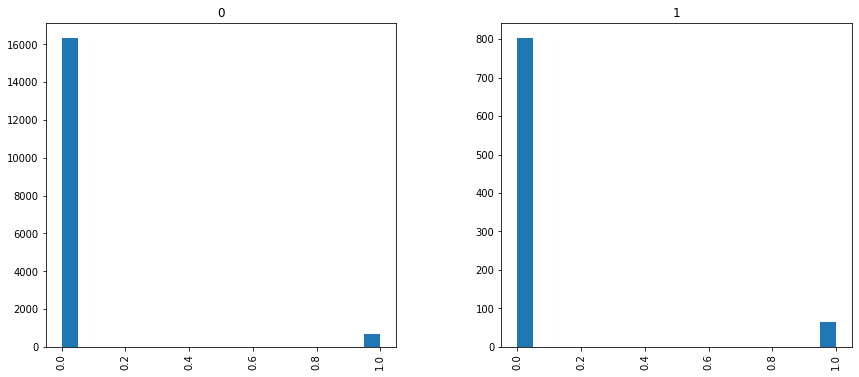

-----------------------------------------------------------
has_company_logo


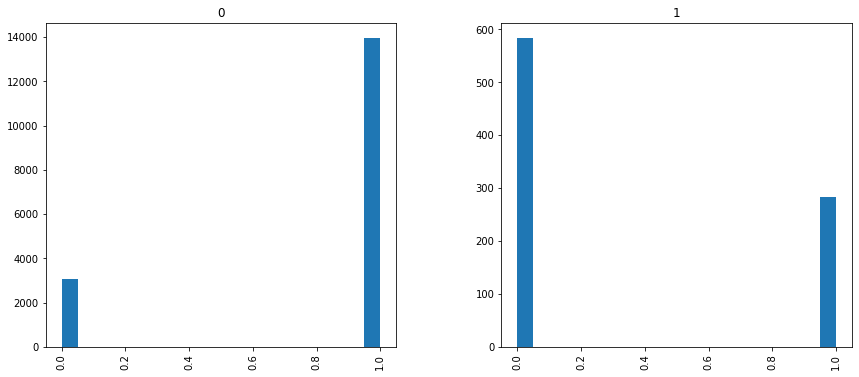

-----------------------------------------------------------
has_questions


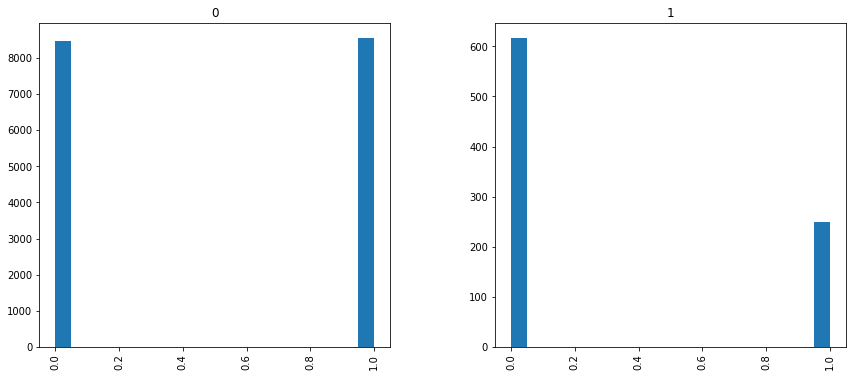

-----------------------------------------------------------
employment_type


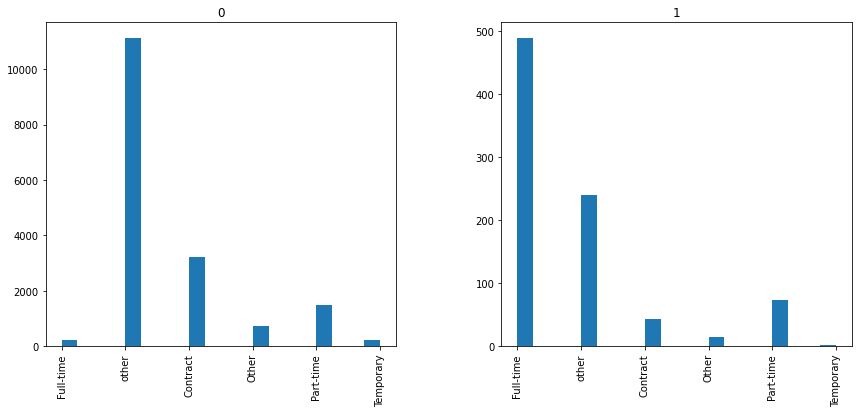

-----------------------------------------------------------
required_experience


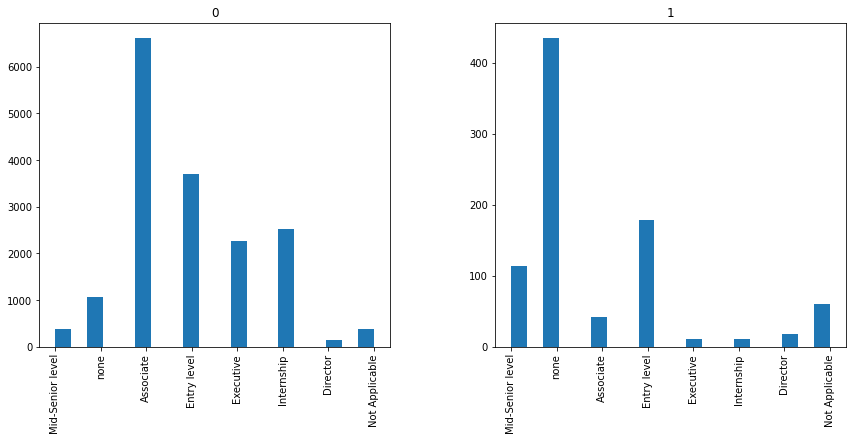

-----------------------------------------------------------
required_education


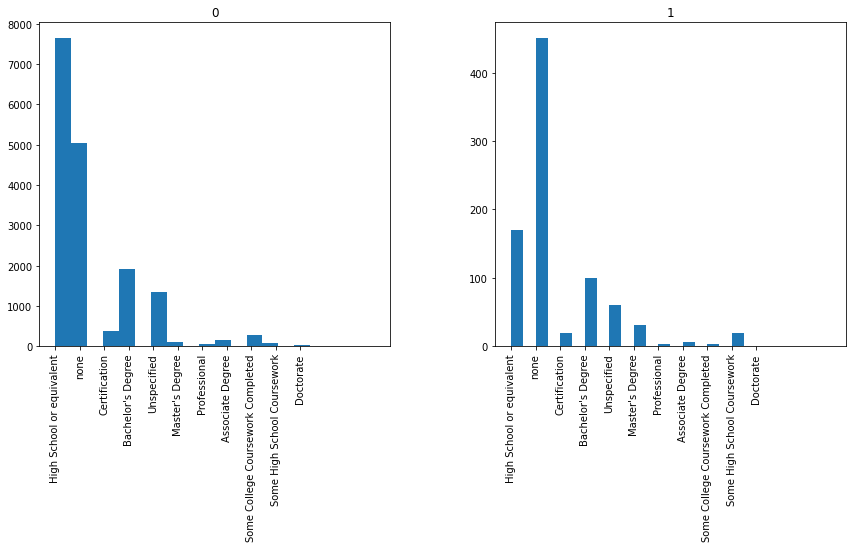

-----------------------------------------------------------
nchar_title


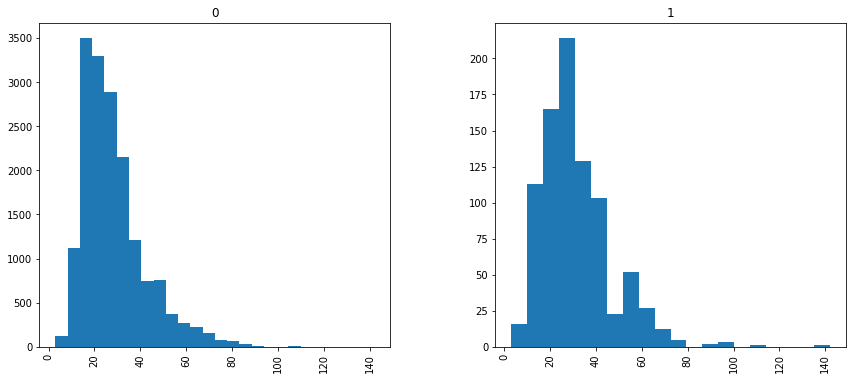

-----------------------------------------------------------
nchar_department


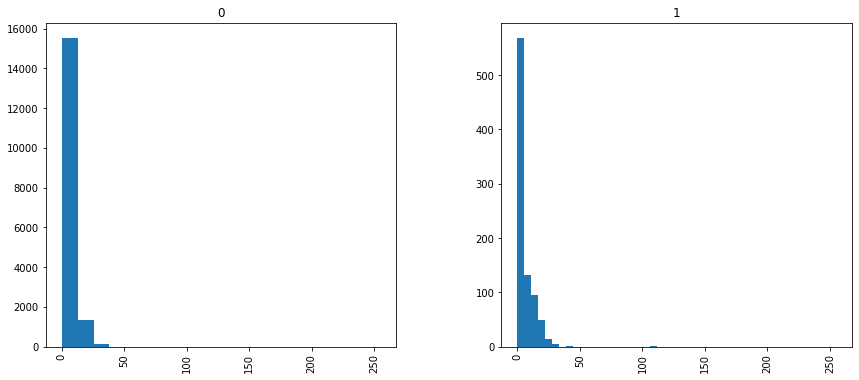

-----------------------------------------------------------
nchar_company_profile


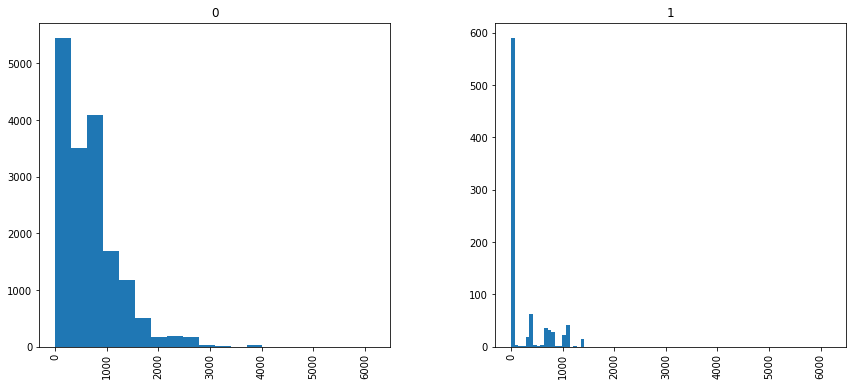

-----------------------------------------------------------
nchar_description


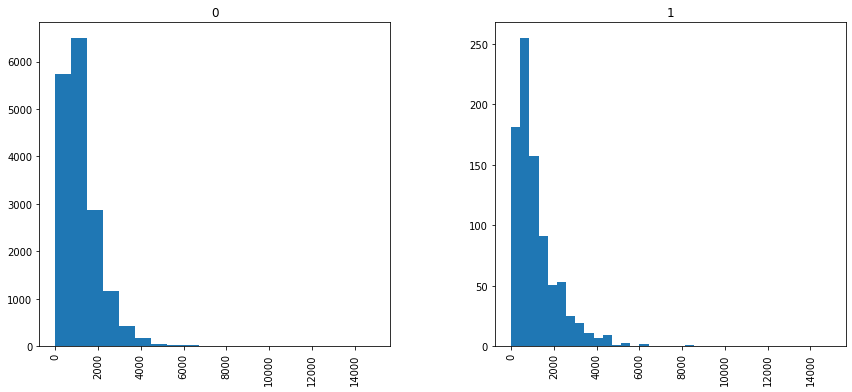

-----------------------------------------------------------
nchar_requirements


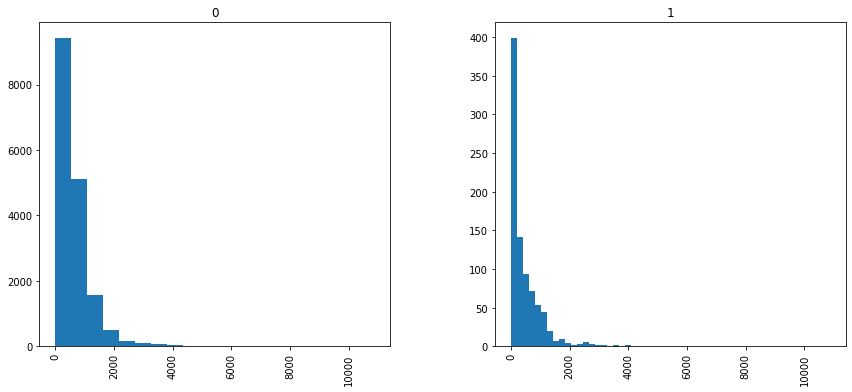

-----------------------------------------------------------
nchar_benefits


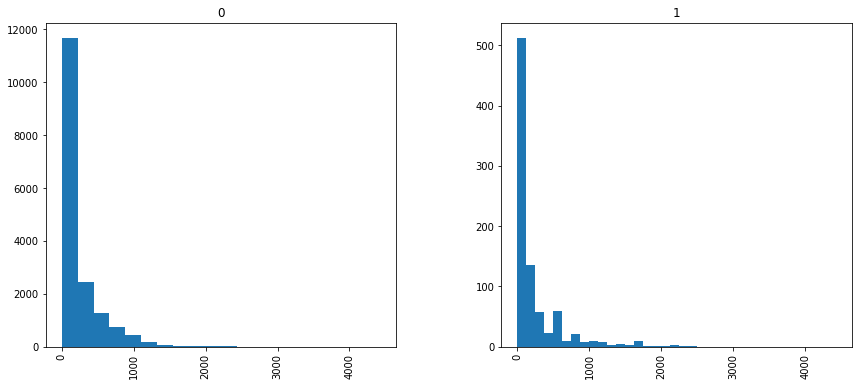

-----------------------------------------------------------
nword_title


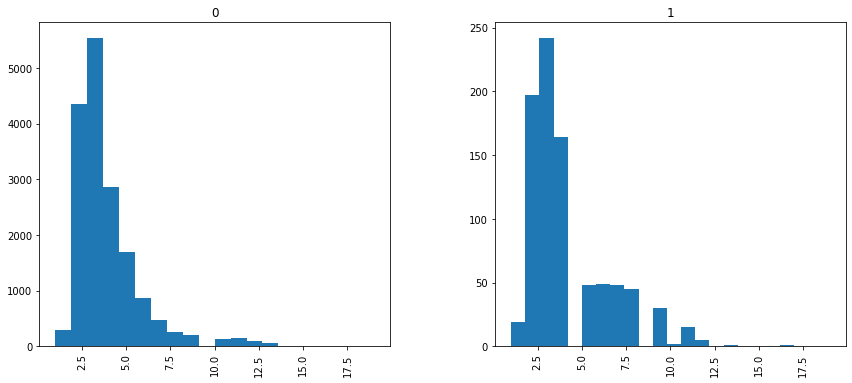

-----------------------------------------------------------
nword_department


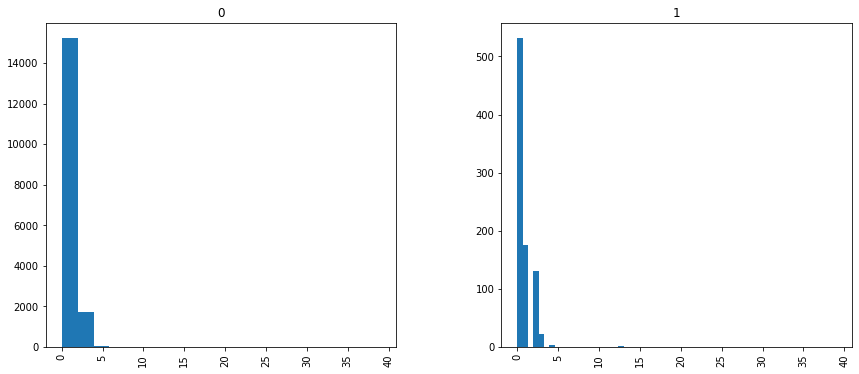

-----------------------------------------------------------
nword_company_profile


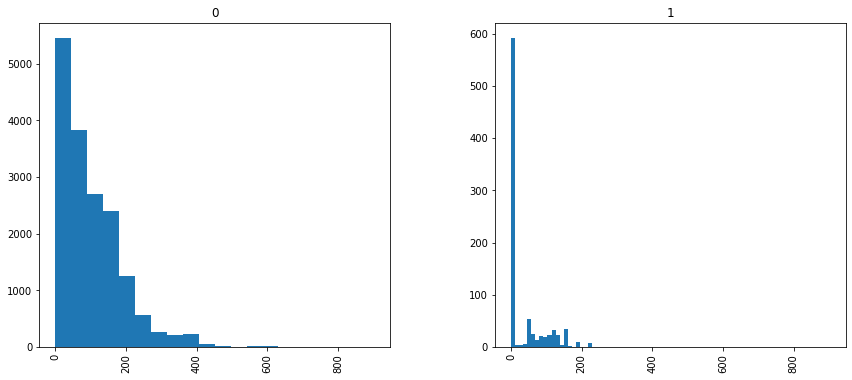

-----------------------------------------------------------
nword_description


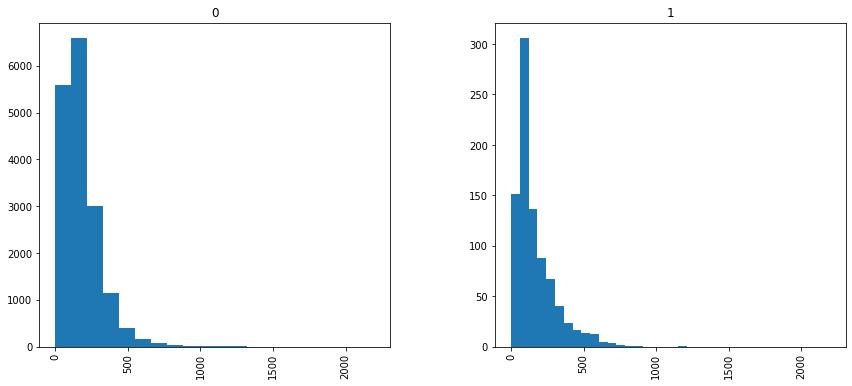

-----------------------------------------------------------
nword_requirements


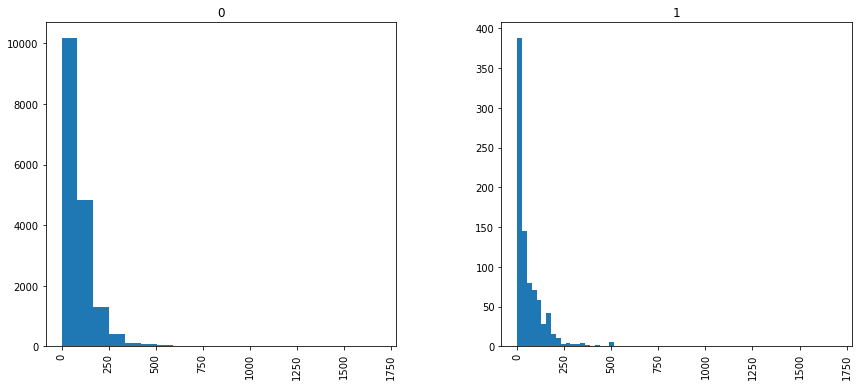

-----------------------------------------------------------
nword_benefits


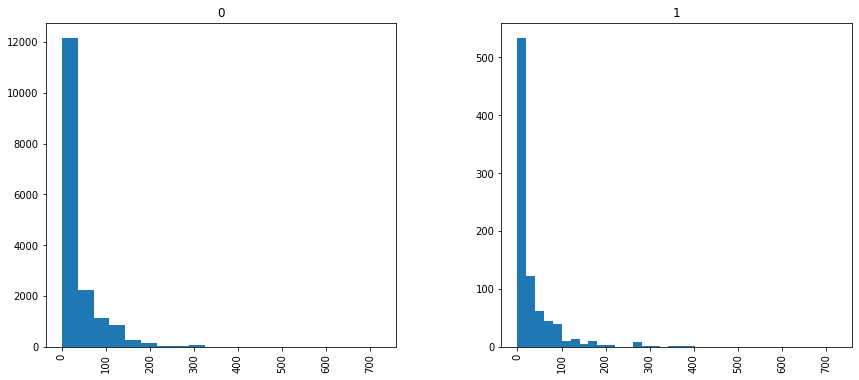

In [ ]:
# sns.pairplot(data=df[['fraudulent', 'nchar_title', 'nchar_department', 'nchar_company_profile', 'nchar_description',
#                       'nchar_requirements', 'nchar_benefits']],
#              hue="fraudulent", height=3, aspect=2);

FOCUS_COLS=['telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
            'required_experience','required_education', 'nchar_title', 'nchar_department',
            'nchar_company_profile', 'nchar_description',
            'nchar_requirements', 'nchar_benefits', 'nword_title', 'nword_department',
            'nword_company_profile', 'nword_description', 'nword_requirements', 'nword_benefits']
for col in FOCUS_COLS:
    print('-----------------------------------------------------------')
    print(col)
    df.hist(column=col, by='fraudulent', bins=20, grid=True, xrot=90, figsize=(14,6), sharex=True)
    plt.show()

# Metrics

In [ ]:
def evaluate(labels, scores, roc=True):
    """Print metrics included Confusion matrix, accuracy, Precision, Recall, F1 score per class."""
    # metrics = sklm.precision_recall_fscore_support(labels, scores)
    labels=labels.astype(np.float32)
    scores2=(scores>0.5).astype(np.float32).reshape(-1,)

    print('Classification report:')
    report = sklm.classification_report(labels, scores2)
    print(report)

    # print confusion matrix
    conf = sklm.confusion_matrix(labels, scores2)
    print('Confusion matrix:')
    print(conf)

    # plot confusion matrix
    n_conf=sklm.confusion_matrix(labels, scores2, normalize='true')
    df_conf = pd.DataFrame(conf, index = ['Actual:Negative', 'Actual: Positive'],
                    columns = ['Predicted: Negative', 'Predicted: Positve'])
    plt.figure(figsize = (5,5))
    sns.heatmap(df_conf, annot=True, fmt='.2f')
    plt.show()

    # plot ROC
    if roc:
        fpr, tpr, thresholds = roc_curve(labels, scores, pos_label = 1.)
        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='darkorange',
                lw=lw, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) curve')
        plt.legend(loc="lower right")
        plt.show()

# Train a model base on only text  
Helping to find right way to extract features from text only.

In [ ]:
# columns which may impact the classification
SUB_COLS=['fraudulent', 'alltext', 'employment_type', 'required_experience', 'required_education', 'has_company_logo', 'has_questions',
          'nchar_department', 'nchar_company_profile','nchar_requirements', 'nword_title','nword_department',
          'nword_company_profile','nword_requirements']
focus=df[SUB_COLS]
print(focus.shape)

(17880, 14)


In [ ]:
indicator_df=pd.get_dummies(focus, sparse=True, dtype=np.float32, columns=['employment_type', 'required_experience', 'required_education'])
print(indicator_df.shape)
indicator_df.sample(5)

(17880, 39)


,fraudulent,alltext,has_company_logo,has_questions,nchar_department,nchar_company_profile,nchar_requirements,nword_title,nword_department,nword_company_profile,nword_requirements,employment_type_Contract,employment_type_Full-time,employment_type_Other,employment_type_Part-time,employment_type_Temporary,employment_type_other,required_experience_Associate,required_experience_Director,required_experience_Entry level,required_experience_Executive,required_experience_Internship,required_experience_Mid-Senior level,required_experience_Not Applicable,required_experience_none,required_education_Associate Degree,required_education_Bachelor's Degree,required_education_Certification,required_education_Doctorate,required_education_High School or equivalent,required_education_Master's Degree,required_education_Professional,required_education_Some College Coursework Completed,required_education_Some High School Coursework,required_education_Unspecified,required_education_Vocational,required_education_Vocational - Degree,required_education_Vocational - HS Diploma,required_education_none
9273,0,tech co founder gr i athens cultinet is linked...,1,1,0,707,1023,3,0,112,137,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
165,0,sales and marketing intern gb london digital s...,1,1,0,406,991,4,0,58,155,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5821,0,college marketing rep seattle us wa seattle m...,1,1,10,686,257,4,1,103,39,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
15515,0,lead data scientist gb lnd london we re thread...,1,0,0,514,648,3,0,93,106,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12990,0,sales manager za gt rivonia sales department 4...,0,0,16,0,111,2,2,0,14,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X=indicator_df.to_numpy()
Y=X[:, 0].astype(np.int8)
X=X[:, 1:]
print(X.shape, Y.shape)

(17880, 38) (17880,)


In [ ]:
x_train, x_test, y_train, y_test=train_test_split(X[:, 0], Y, test_size=0.3, random_state=42)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
print(y_train)

(12516,) (12516,) (5364,) (5364,)
[0 0 0 ... 0 0 0]


In [ ]:
vectorizer=vectorizer=CountVectorizer(lowercase=True, analyzer='word', stop_words=None, max_df=0.75,
                           max_features=1000, ngram_range=(1,2))
x_train_bin=vectorizer.fit_transform(x_train).todense()
x_test_bin=vectorizer.transform(x_test).todense()
print(x_train_bin.shape)
print(x_train_bin)

(12516, 1000)
[[0 0 0 ... 0 0 3]
 [0 1 0 ... 0 1 2]
 [0 0 0 ... 0 0 5]
 ...
 [1 0 2 ... 0 0 0]
 [0 0 0 ... 0 1 3]
 [0 0 0 ... 0 0 1]]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   48.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   48.1s finished


Classification report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     11921
         1.0       0.99      0.87      0.93       595

    accuracy                           0.99     12516
   macro avg       0.99      0.94      0.96     12516
weighted avg       0.99      0.99      0.99     12516

Confusion matrix:
[[11914     7]
 [   77   518]]


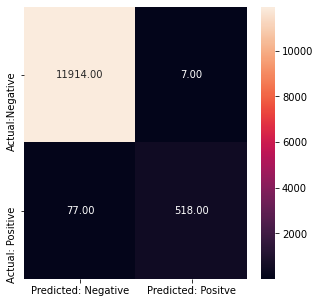

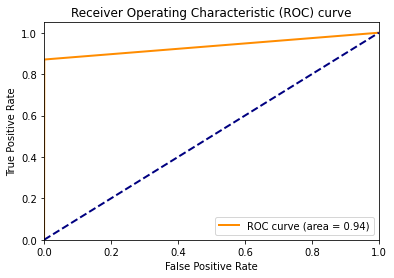

Classification report:
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      5093
         1.0       0.83      0.69      0.76       271

    accuracy                           0.98      5364
   macro avg       0.91      0.84      0.87      5364
weighted avg       0.98      0.98      0.98      5364

Confusion matrix:
[[5056   37]
 [  84  187]]


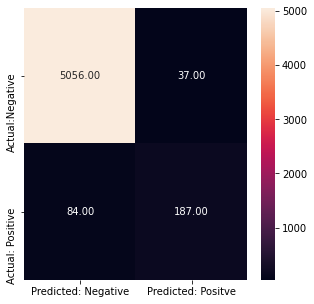

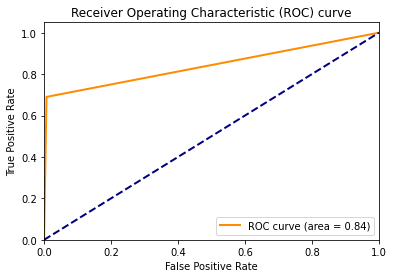

In [ ]:
# clf=MultinomialNB()
clf=LogisticRegression(C=0.2, solver='lbfgs', max_iter=1000, verbose=10, n_jobs=-1)
clf.fit(x_train_bin, y_train)
y_train_pred=clf.predict(x_train_bin)
y_test_pred=clf.predict(x_test_bin)
evaluate(y_train, y_train_pred)
evaluate(y_test, y_test_pred)

Iteration 1, loss = 0.17173133
Iteration 2, loss = 0.06009963
Iteration 3, loss = 0.02850044
Iteration 4, loss = 0.01026083
Iteration 5, loss = 0.00414394
Iteration 6, loss = 0.00357636
Iteration 7, loss = 0.00273197
Iteration 8, loss = 0.00121040
Iteration 9, loss = 0.00083650
Iteration 10, loss = 0.00068779
Iteration 11, loss = 0.00061801
Iteration 12, loss = 0.00056492
Iteration 13, loss = 0.00053894
Iteration 14, loss = 0.00050827
Iteration 15, loss = 0.00049171
Iteration 16, loss = 0.00048009
Iteration 17, loss = 0.00047214
Iteration 18, loss = 0.00046233
Iteration 19, loss = 0.00045691
Iteration 20, loss = 0.00045152
Iteration 21, loss = 0.00044625
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Classification report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     11921
         1.0       1.00      1.00      1.00       595

    accuracy                           1.00     12516
   mac

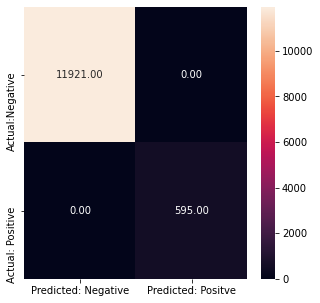

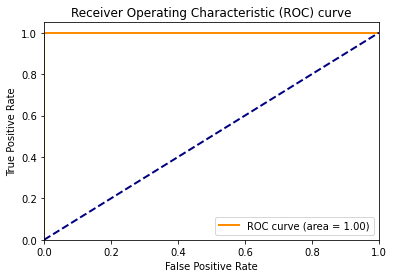

Classification report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      5093
         1.0       0.93      0.74      0.82       271

    accuracy                           0.98      5364
   macro avg       0.96      0.87      0.91      5364
weighted avg       0.98      0.98      0.98      5364

Confusion matrix:
[[5079   14]
 [  71  200]]


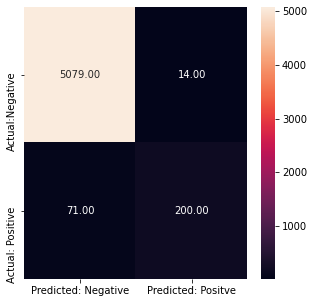

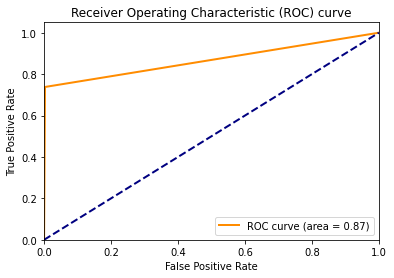

In [ ]:
clf= MLPClassifier(hidden_layer_sizes=(1024, 256), activation='relu', max_iter=1000, random_state=42, verbose=10)
clf.fit(x_train_bin, y_train)
y_train_pred=clf.predict(x_train_bin)
y_test_pred=clf.predict(x_test_bin)
evaluate(y_train, y_train_pred)
evaluate(y_test, y_test_pred)

# Grid Search to figure out the suitable text vectorizer

In [ ]:
def grid_search(pipeline, parameters, x_train, y_train):
    # find the best parameters for both the feature extraction and the classifier
    grid_searcher = GridSearchCV(pipeline, parameters, scoring='f1',
                               refit='f1', n_jobs=1,  verbose=10, cv=3 )
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(parameters)
    t0 = time()
    grid_searcher.fit(x_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print("Best score: %0.3f" % grid_searcher.best_score_)
    print("Best parameters set:")
    best_estimator=grid_searcher.best_estimator_
    best_parameters = best_estimator.get_params()
    print(best_parameters)
    return grid_searcher, best_estimator

In [ ]:
parameters = {
    'vectorizer__stop_words': (None, 'english'),
    'vectorizer__max_features': (500, 1000, 2000, 4000),
    'vectorizer__ngram_range': ((1, 1), (1, 2), (1,3)), 
    'clf__C': (0.03, 0.1, 0.3, 0.5, 1),
    'clf__class_weight': ('balanced', None)
}
pipeline = Pipeline([
    ('vectorizer', CountVectorizer(lowercase=True, analyzer='word', max_df=0.75)),
    ('todense', FunctionTransformer(lambda x: x.todense(), accept_sparse=True)),
    ('clf', LogisticRegression(solver='lbfgs', max_iter=1000, verbose=10, n_jobs=1))
])
searcher, best_clf=grid_search(pipeline, parameters, x_train, y_train)

Performing grid search...
pipeline: ['vectorizer', 'todense', 'clf']
parameters:
{'vectorizer__stop_words': (None, 'english'), 'vectorizer__max_features': (500, 1000, 2000, 4000), 'vectorizer__ngram_range': ((1, 1), (1, 2), (1, 3)), 'clf__C': (0.03, 0.1, 0.3, 0.5, 1), 'clf__class_weight': ('balanced', None)}
Fitting 3 folds for each of 240 candidates, totalling 720 fits
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.540, total=   6.1s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.500, total=   5.4s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.484, total=   5.8s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   17.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.507, total=   5.5s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   22.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.488, total=   5.3s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   28.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.480, total=   5.4s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   33.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.546, total=  13.2s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   46.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.489, total=  13.0s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   59.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.481, total=  14.6s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.505, total=  10.4s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.482, total=  10.8s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.481, total=  10.4s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.545, total=  23.3s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.480, total=  23.8s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.487, total=  25.4s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.506, total=  19.7s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.485, total=  19.0s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.475, total=  18.3s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.618, total=   7.5s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.557, total=   7.5s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.566, total=   8.3s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.601, total=   7.3s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.548, total=   6.8s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.557, total=   6.4s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.610, total=  15.4s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.581, total=  15.4s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.567, total=  16.0s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.608, total=  12.2s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.551, total=  12.1s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.562, total=  12.6s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.612, total=  25.3s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.574, total=  25.6s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.561, total=  28.3s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.602, total=  21.0s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.554, total=  20.4s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.562, total=  21.0s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.1s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.685, total=  10.5s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.3s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.623, total=  10.5s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.7s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.613, total=  10.7s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.6s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.669, total=  11.0s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.609, total=   9.5s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.8s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.618, total=   9.6s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.3s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.694, total=  18.3s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.9s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.646, total=  19.2s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.5s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.616, total=  18.4s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.6s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.676, total=  17.7s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.4s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.604, total=  15.8s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.4s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.616, total=  17.3s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.4s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.690, total=  31.2s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.9s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.642, total=  30.3s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.4s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.619, total=  30.7s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.2s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.672, total=  25.6s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.606, total=  22.6s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.6s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.617, total=  23.9s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.3s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.726, total=  20.4s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.9s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.640, total=  18.1s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.4s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.639, total=  17.7s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.0s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.718, total=  17.0s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.5s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.646, total=  15.0s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.0s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.660, total=  14.9s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.4s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.728, total=  26.8s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.1s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.659, total=  23.6s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.1s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.643, total=  24.8s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.1s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.728, total=  23.6s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.8s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.651, total=  20.1s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.9s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.658, total=  20.6s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.6s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.721, total=  41.3s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.4s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.648, total=  35.6s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.0s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.649, total=  37.8s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.0s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.720, total=  32.8s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.3s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.638, total=  30.3s
[CV] clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.3s finished


[CV]  clf__C=0.03, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.660, total=  31.1s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.507, total=   5.1s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.569, total=   5.4s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.563, total=   5.1s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.477, total=   4.7s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.536, total=   4.9s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.498, total=   4.9s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.498, total=  13.6s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.536, total=  13.2s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.544, total=  13.4s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.447, total=  11.5s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.527, total=  10.3s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.456, total=  10.4s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.490, total=  23.9s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.538, total=  23.7s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.526, total=  26.1s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.452, total=  18.4s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.520, total=  18.0s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.446, total=  18.6s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.589, total=   6.3s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.646, total=   7.2s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.646, total=   7.7s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.554, total=   6.7s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.593, total=   6.2s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.637, total=   6.9s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.570, total=  15.3s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.645, total=  13.5s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.638, total=  14.1s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.559, total=  11.9s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.620, total=  12.1s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.648, total=  12.4s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.560, total=  26.0s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.635, total=  28.3s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.642, total=  25.5s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.554, total=  20.1s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.618, total=  20.0s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.646, total=  21.0s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.8s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.639, total=  10.0s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.9s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.683, total=  10.1s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.8s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.685, total=   9.9s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.9s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.638, total=  10.1s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.647, total=   9.0s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.7s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.704, total=   9.9s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.5s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.646, total=  18.0s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.2s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.683, total=  18.7s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.9s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.677, total=  18.6s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.7s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.621, total=  15.7s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.638, total=  16.0s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.5s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.705, total=  15.3s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.8s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.642, total=  29.4s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.8s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.698, total=  28.3s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.1s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.685, total=  30.7s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.3s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.605, total=  25.2s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.645, total=  22.3s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.1s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.703, total=  23.8s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.3s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.660, total=  15.4s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.2s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.706, total=  15.6s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.5s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.717, total=  16.3s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.8s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.665, total=  15.0s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.9s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.684, total=  14.3s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.8s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.712, total=  15.3s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.3s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.679, total=  25.2s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.1s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.712, total=  22.2s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.0s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.732, total=  23.3s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.5s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.677, total=  21.8s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.7s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.679, total=  19.9s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.2s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.709, total=  18.9s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.2s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.681, total=  37.4s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.3s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.708, total=  34.2s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.3s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.727, total=  36.9s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.4s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.671, total=  28.8s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.6s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.688, total=  28.8s
[CV] clf__C=0.03, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.2s finished


[CV]  clf__C=0.03, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.713, total=  30.2s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.555, total=   6.2s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.520, total=   6.2s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.502, total=   6.5s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.530, total=   6.0s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.519, total=   5.8s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.512, total=   5.8s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.541, total=  13.9s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.519, total=  13.6s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.516, total=  13.6s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.534, total=  11.6s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.514, total=  11.6s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.513, total=  13.3s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.550, total=  24.5s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.494, total=  23.8s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.520, total=  23.5s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.537, total=  19.1s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.518, total=  20.4s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.504, total=  20.1s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.5s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.658, total=   9.3s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.581, total=   9.4s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.0s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.592, total=   9.1s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.626, total=   8.0s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.578, total=   7.8s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.590, total=   8.2s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.6s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.647, total=  16.7s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.597, total=  15.4s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.604, total=  16.1s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.646, total=  14.7s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.581, total=  13.5s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.594, total=  13.9s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.645, total=  26.5s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.596, total=  26.8s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.602, total=  28.2s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.650, total=  22.3s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.584, total=  21.0s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.592, total=  22.3s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.0s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.716, total=  14.9s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.8s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.648, total=  13.4s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.6s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.649, total=  14.2s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.0s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.697, total=  13.6s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.1s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.623, total=  11.7s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.8s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.648, total=  12.1s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.2s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.724, total=  21.6s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.0s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.652, total=  19.8s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.4s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.644, total=  19.9s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.4s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.698, total=  17.8s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.8s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.634, total=  18.3s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.8s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.647, total=  18.0s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.3s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.708, total=  34.8s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.4s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.656, total=  30.6s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.2s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.651, total=  31.6s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.4s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.704, total=  28.6s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.1s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.618, total=  24.3s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.6s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.649, total=  25.5s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.6s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.747, total=  22.2s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.5s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.672, total=  20.2s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.8s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.679, total=  23.0s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.6s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.740, total=  22.3s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.8s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.664, total=  18.4s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.1s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.679, total=  17.3s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.7s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.745, total=  31.1s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.5s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.677, total=  27.2s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.7s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.686, total=  35.7s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.4s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.754, total=  28.2s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.1s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.659, total=  22.8s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.8s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.693, total=  25.5s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.0s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.748, total=  47.0s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.7s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.686, total=  41.1s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.9s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.693, total=  38.5s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.8s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.751, total=  39.0s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.8s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.660, total=  32.3s
[CV] clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.3s finished


[CV]  clf__C=0.1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.686, total=  35.5s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.582, total=   5.8s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.602, total=   5.9s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.629, total=   5.4s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.570, total=   5.6s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.560, total=   5.3s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.608, total=   5.9s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.548, total=  14.0s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.607, total=  13.6s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.611, total=  13.5s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.544, total=  11.1s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.585, total=  10.9s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.608, total=  10.6s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.553, total=  23.7s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.584, total=  23.9s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.603, total=  24.1s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.552, total=  21.4s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.580, total=  17.6s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.605, total=  17.8s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.680, total=   8.5s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.678, total=   8.3s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.703, total=   8.3s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.663, total=   7.1s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.645, total=   7.0s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.3s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.703, total=   8.1s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.686, total=  16.0s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.704, total=  16.2s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.710, total=  16.1s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.647, total=  13.2s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.651, total=  12.0s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.719, total=  13.0s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.690, total=  25.2s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.703, total=  24.8s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.707, total=  25.5s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.657, total=  20.7s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.651, total=  19.0s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.724, total=  20.5s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.7s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.719, total=  12.8s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.1s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.725, total=  12.2s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.6s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.737, total=  12.9s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.6s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.728, total=  11.9s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.3s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.683, total=  10.0s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.0s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.739, total=  10.7s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.8s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.724, total=  19.6s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.0s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.723, total=  20.0s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.0s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.738, total=  20.3s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.9s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.726, total=  17.3s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.6s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.667, total=  15.2s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.6s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.738, total=  17.1s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.9s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.721, total=  30.2s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.9s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.717, total=  30.5s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.8s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.732, total=  30.0s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.6s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.712, total=  25.4s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.4s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.673, total=  22.8s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.0s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.744, total=  24.5s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.6s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.730, total=  22.3s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.8s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.737, total=  20.9s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.0s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.743, total=  20.8s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.0s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.753, total=  18.2s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.3s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.701, total=  15.5s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.9s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.746, total=  18.2s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.2s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.766, total=  32.6s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.0s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.754, total=  26.2s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.8s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.769, total=  28.0s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.8s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.763, total=  25.3s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.3s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.717, total=  21.8s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.9s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.738, total=  24.9s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.2s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.752, total=  41.5s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.0s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.757, total=  37.5s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.4s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.765, total=  38.7s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.8s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.756, total=  34.3s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.3s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.722, total=  27.9s
[CV] clf__C=0.1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.0s finished


[CV]  clf__C=0.1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.742, total=  34.3s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.562, total=   7.9s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.528, total=   7.0s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.517, total=   7.4s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.552, total=   6.6s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.511, total=   6.9s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.529, total=   7.0s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.1s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.553, total=  14.9s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.526, total=  14.3s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.524, total=  14.5s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.548, total=  12.9s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.525, total=  12.2s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.530, total=  12.6s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.549, total=  25.3s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.510, total=  24.3s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.517, total=  25.5s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.547, total=  20.8s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.528, total=  19.5s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.522, total=  19.5s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.6s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.672, total=  11.7s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.6s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.618, total=  10.6s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.5s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.618, total=   9.8s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.4s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.642, total=  10.2s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.1s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.584, total=   8.8s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.0s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.616, total=  10.2s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.5s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.640, total=  18.7s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.3s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.594, total=  16.9s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.8s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.617, total=  17.7s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.8s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.660, total=  16.0s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.7s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.602, total=  14.5s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.8s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.604, total=  16.2s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.7s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.646, total=  27.6s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.6s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.593, total=  27.4s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.4s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.612, total=  27.1s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.0s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.664, total=  23.2s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.0s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.604, total=  21.2s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.0s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.610, total=  22.6s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.5s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.723, total=  17.1s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.1s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.658, total=  16.4s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.3s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.659, total=  14.8s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.2s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.707, total=  14.2s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.8s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.633, total=  12.5s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.6s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.667, total=  15.2s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.1s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.730, total=  24.5s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.6s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.668, total=  20.2s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.1s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.667, total=  23.7s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.7s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.704, total=  21.3s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.2s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.631, total=  18.3s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.6s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.656, total=  20.1s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.6s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.709, total=  35.4s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.9s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.656, total=  30.1s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.4s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.668, total=  32.8s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.3s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.718, total=  30.4s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.3s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.628, total=  25.7s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.1s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.662, total=  28.4s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.3s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.748, total=  27.6s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.5s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.688, total=  23.0s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.1s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.692, total=  27.6s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.7s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.749, total=  26.5s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.6s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.661, total=  20.9s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.5s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.690, total=  23.4s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.7s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.773, total=  37.8s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.5s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.703, total=  28.6s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.0s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.699, total=  35.7s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.1s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.761, total=  31.1s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.9s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.674, total=  26.9s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.3s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.708, total=  30.2s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   27.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   27.6s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.763, total=  50.4s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.3s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.700, total=  41.7s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.8s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.702, total=  46.5s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.7s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.751, total=  43.2s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.7s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.655, total=  35.2s
[CV] clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.6s finished


[CV]  clf__C=0.3, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.701, total=  37.7s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.593, total=   6.4s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.593, total=   6.2s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.625, total=   6.7s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.606, total=   6.5s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.593, total=   5.8s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.649, total=   5.9s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.576, total=  13.7s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.600, total=  14.1s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.604, total=  13.6s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.593, total=  11.8s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.625, total=  11.9s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.639, total=  11.6s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.595, total=  24.7s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.591, total=  24.0s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.618, total=  24.1s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.593, total=  19.3s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.635, total=  19.6s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.641, total=  18.8s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.1s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.697, total=  10.1s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.7s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.717, total=   9.7s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.2s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.681, total=  10.0s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.703, total=   8.7s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.3s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.646, total=   7.9s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.0s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.722, total=   8.8s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.8s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.723, total=  16.7s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.5s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.672, total=  16.3s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.8s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.705, total=  16.4s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.693, total=  14.0s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.659, total=  14.0s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.4s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.715, total=  14.8s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.1s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.713, total=  27.4s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.4s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.668, total=  28.3s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.0s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.707, total=  27.4s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.695, total=  22.1s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.3s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.654, total=  20.6s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.714, total=  21.9s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.6s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.741, total=  15.0s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.9s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.709, total=  13.4s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.3s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.749, total=  14.7s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.4s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.754, total=  12.3s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.6s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.695, total=  11.6s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.7s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.736, total=  13.2s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.8s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.756, total=  22.1s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.1s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.720, total=  20.7s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.0s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.737, total=  23.2s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.5s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.740, total=  19.3s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.7s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.685, total=  17.2s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.5s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.737, total=  18.7s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.3s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.743, total=  32.8s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.2s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.731, total=  33.2s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.2s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.735, total=  33.1s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.1s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.734, total=  26.6s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.5s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.693, total=  24.8s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.1s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.728, total=  26.1s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.6s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.768, total=  24.5s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.5s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.742, total=  24.3s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.8s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.772, total=  23.7s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.0s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.779, total=  24.4s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.2s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.733, total=  19.0s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.2s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.754, total=  20.4s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.5s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.780, total=  33.9s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.3s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.728, total=  29.3s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.2s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.768, total=  35.2s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.7s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.770, total=  32.5s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.8s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.720, total=  25.6s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.7s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.744, total=  29.4s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.6s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.770, total=  49.6s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.3s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.741, total=  44.0s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.6s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.763, total=  46.0s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.2s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.770, total=  39.3s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.3s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.717, total=  31.9s
[CV] clf__C=0.3, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.9s finished


[CV]  clf__C=0.3, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.754, total=  35.7s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.566, total=   8.4s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.541, total=   8.6s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.528, total=   7.6s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.1s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.562, total=   7.9s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.515, total=   7.3s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.541, total=   7.4s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.557, total=  15.9s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.517, total=  15.6s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.525, total=  14.3s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.553, total=  13.8s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.531, total=  12.9s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.537, total=  12.9s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.553, total=  26.4s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.0s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.514, total=  26.3s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.528, total=  26.4s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.550, total=  21.7s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.536, total=  20.5s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.529, total=  20.7s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.2s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.670, total=  12.4s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.6s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.632, total=  11.4s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.6s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.631, total=  11.4s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.1s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.645, total=  11.3s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.2s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.584, total=   9.9s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.3s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.620, total=  11.2s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.0s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.639, total=  18.8s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.7s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.596, total=  19.0s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.9s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.611, total=  18.2s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.5s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.671, total=  16.9s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.1s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.599, total=  15.4s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.4s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.627, total=  16.9s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.9s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.649, total=  29.7s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.1s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.603, total=  28.8s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.2s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.611, total=  29.0s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.0s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.675, total=  25.1s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.7s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.598, total=  22.6s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.8s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.628, total=  24.8s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.4s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.721, total=  17.9s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.4s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.670, total=  17.1s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.5s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.658, total=  15.9s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.1s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.727, total=  16.6s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.5s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.647, total=  14.2s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.8s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.674, total=  16.2s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.8s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.739, total=  26.3s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.8s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.674, total=  22.6s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.4s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.664, total=  24.8s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.0s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.706, total=  23.2s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.4s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.638, total=  19.1s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.8s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.665, total=  20.6s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.4s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.713, total=  37.1s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.9s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.658, total=  32.6s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.7s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.673, total=  35.7s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.4s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.712, total=  33.6s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.0s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.636, total=  27.1s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.3s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.670, total=  29.5s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.8s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.749, total=  29.2s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.3s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.695, total=  28.3s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.1s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.697, total=  30.0s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.4s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.746, total=  25.9s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.9s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.668, total=  23.8s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.3s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.704, total=  25.7s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.3s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.772, total=  38.5s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.5s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.702, total=  31.6s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.0s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.696, total=  36.1s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.0s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.755, total=  34.8s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.2s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.685, total=  32.5s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.8s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.708, total=  32.8s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.6s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.769, total=  44.8s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.0s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.703, total=  42.4s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.9s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.701, total=  47.8s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.7s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.741, total=  44.3s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.7s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.662, total=  35.2s
[CV] clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.0s finished


[CV]  clf__C=0.5, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.706, total=  37.6s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.597, total=   7.2s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.601, total=   6.8s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.612, total=   7.4s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.603, total=   7.0s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.605, total=   6.4s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.643, total=   7.0s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.588, total=  15.1s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.587, total=  14.6s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.613, total=  14.9s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.621, total=  13.1s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.615, total=  12.5s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.621, total=  12.0s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.609, total=  26.1s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.581, total=  25.9s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.613, total=  25.5s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.619, total=  21.2s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.617, total=  20.3s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.631, total=  19.9s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.1s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.696, total=  10.9s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.2s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.702, total=  10.2s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.0s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.679, total=  11.3s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.2s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.690, total=  10.0s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.7s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.649, total=   9.3s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.5s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.718, total=   9.4s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.5s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.703, total=  18.7s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.7s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.661, total=  18.1s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.6s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.700, total=  17.6s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.5s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.686, total=  16.4s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.654, total=  14.2s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.9s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.706, total=  15.6s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.2s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.701, total=  28.4s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.9s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.677, total=  28.8s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.4s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.712, total=  28.6s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.0s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.688, total=  24.3s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.665, total=  22.3s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.5s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.713, total=  23.5s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.2s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.748, total=  15.4s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.1s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.716, total=  14.5s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.6s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.755, total=  15.7s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.7s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.762, total=  14.2s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.6s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.687, total=  12.8s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.3s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.742, total=  13.5s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.4s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.747, total=  24.3s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.4s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.715, total=  23.5s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.6s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.735, total=  24.9s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.5s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.749, total=  20.8s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.7s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.694, total=  17.7s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.2s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.725, total=  20.5s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.5s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.744, total=  35.4s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.6s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.708, total=  34.7s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.9s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.732, total=  35.4s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.9s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.735, total=  30.8s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.3s finished


[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 
[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.691, total=  26.9s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.3s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.726, total=  29.2s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.9s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.771, total=  28.5s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.5s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.738, total=  24.1s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.7s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.767, total=  26.9s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.6s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.791, total=  25.9s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.8s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.726, total=  20.6s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.3s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.765, total=  20.3s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.3s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.786, total=  39.1s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.2s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.729, total=  30.8s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.5s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.765, total=  35.3s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.2s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.774, total=  31.1s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.5s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.712, total=  26.4s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.6s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.750, total=  28.5s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.4s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.763, total=  47.0s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.9s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.735, total=  43.9s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.5s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.756, total=  47.9s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.8s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.784, total=  41.5s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.6s finished


[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 
[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.708, total=  34.8s
[CV] clf__C=0.5, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.7s finished


[CV]  clf__C=0.5, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.754, total=  36.3s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.560, total=   9.1s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.4s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.545, total=   9.2s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.534, total=   8.7s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.5s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.559, total=   9.0s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.525, total=   8.4s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.543, total=   8.0s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.1s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.563, total=  17.1s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.4s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.518, total=  17.5s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.2s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.535, total=  17.4s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.8s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.549, total=  15.4s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.531, total=  14.7s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.544, total=  14.1s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.6s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.560, total=  28.3s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.0s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.526, total=  28.7s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.3s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.547, total=  28.6s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.6s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.549, total=  22.7s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.541, total=  22.3s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.533, total=  21.9s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.0s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.667, total=  13.5s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.6s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.632, total=  12.0s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.5s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.630, total=  13.6s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.3s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.658, total=  13.2s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.5s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.571, total=  11.6s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.4s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.625, total=  12.1s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.3s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.655, total=  19.8s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.2s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.601, total=  19.1s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.0s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.618, total=  20.0s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.7s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.675, total=  18.1s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.6s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.591, total=  17.0s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.4s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.626, total=  18.3s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.6s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.650, total=  31.9s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.6s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.600, total=  30.5s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.7s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.611, total=  30.9s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.8s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.674, total=  26.2s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.6s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.592, total=  24.0s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.5s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.632, total=  26.2s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.7s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.719, total=  19.2s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.8s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.662, total=  16.7s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.0s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.664, total=  19.1s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.2s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.741, total=  18.1s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.5s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.654, total=  16.2s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.1s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.671, total=  17.9s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.4s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.738, total=  30.3s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.5s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.679, total=  25.2s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.4s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.664, total=  27.6s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.7s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.707, total=  24.8s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.6s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.644, total=  20.2s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.2s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.665, total=  24.2s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.1s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.717, total=  40.9s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.5s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.664, total=  35.8s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.0s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.675, total=  39.4s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.0s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.707, total=  33.1s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.8s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.635, total=  29.1s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.4s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.678, total=  31.4s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.1s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.751, total=  33.0s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.5s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.700, total=  26.8s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   30.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   30.7s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.704, total=  36.2s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.8s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.755, total=  26.7s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.4s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.676, total=  28.9s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.7s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.709, total=  26.3s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   30.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   30.0s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.772, total=  42.5s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.3s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.709, total=  31.7s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   30.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   30.9s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.704, total=  42.4s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   27.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   27.8s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.755, total=  38.6s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.1s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.681, total=  30.5s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.4s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.708, total=  33.7s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   30.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   30.3s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.769, total=  54.8s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.6s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.705, total=  45.5s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   27.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   27.8s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.709, total=  51.6s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   30.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   30.7s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.744, total=  49.2s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.9s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.668, total=  37.2s
[CV] clf__C=1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.7s finished


[CV]  clf__C=1, clf__class_weight=balanced, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.705, total=  44.0s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.618, total=   8.2s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.603, total=   8.6s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.591, total=   7.8s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.586, total=   7.3s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.594, total=   7.8s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.623, total=   7.6s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.576, total=  15.8s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.7s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.559, total=  16.4s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.606, total=  16.2s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.1s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.616, total=  13.4s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.605, total=  12.8s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.609, total=  13.7s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.601, total=  26.8s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.578, total=  26.7s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.612, total=  27.0s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.617, total=  21.1s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.605, total=  21.0s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=500, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.603, total=  21.0s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.6s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.704, total=  11.5s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.8s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.699, total=  10.8s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.6s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.677, total=  12.0s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.2s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.684, total=  10.9s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.7s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.656, total=   9.9s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.9s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.696, total=  10.6s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.7s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.707, total=  19.2s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.4s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.648, total=  18.4s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.7s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.684, total=  18.7s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.9s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.688, total=  17.4s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.5s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.660, total=  14.9s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.9s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.691, total=  16.3s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.7s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.686, total=  29.8s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.3s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.649, total=  30.4s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.9s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.691, total=  31.3s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.0s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.686, total=  25.2s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.5s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.656, total=  22.5s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.4s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=1000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.693, total=  24.4s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.7s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.744, total=  18.3s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.0s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.701, total=  15.5s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.3s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.738, total=  18.5s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.3s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.740, total=  16.7s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.6s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.670, total=  13.2s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.4s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.732, total=  14.8s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.2s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.730, total=  24.5s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.7s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.707, total=  26.1s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.1s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.721, total=  25.7s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.8s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.736, total=  24.1s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.4s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.694, total=  19.5s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.4s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.730, total=  23.8s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.2s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.736, total=  38.6s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.7s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.696, total=  35.4s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.2s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.727, total=  37.1s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.4s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.743, total=  31.6s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.3s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.685, total=  27.9s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.3s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=2000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.721, total=  30.4s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.5s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.766, total=  31.2s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.5s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.717, total=  26.5s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.7s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=None, score=0.765, total=  28.9s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.7s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.784, total=  25.2s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.6s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.715, total=  21.9s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.8s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 1), vectorizer__stop_words=english, score=0.768, total=  22.9s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.3s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.789, total=  35.9s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.1s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.719, total=  36.9s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.6s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=None, score=0.742, total=  37.7s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.9s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.772, total=  31.5s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.2s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.706, total=  27.5s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.6s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 2), vectorizer__stop_words=english, score=0.756, total=  31.1s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   27.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   27.0s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.770, total=  50.7s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.0s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.728, total=  46.0s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.4s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=None, score=0.747, total=  48.6s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.0s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.778, total=  43.2s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.1s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.713, total=  34.3s
[CV] clf__C=1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.1s finished


[CV]  clf__C=1, clf__class_weight=None, vectorizer__max_features=4000, vectorizer__ngram_range=(1, 3), vectorizer__stop_words=english, score=0.758, total=  39.7s


[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed: 252.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


done in 15174.973s
Best score: 0.763
Best parameters set:
{'memory': None, 'steps': [('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=0.75, max_features=4000, min_df=1,
                ngram_range=(1, 2), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)), ('todense', FunctionTransformer(accept_sparse=True, check_inverse=True,
                    func=<function <lambda> at 0x7f31517027b8>,
                    inv_kw_args=None, inverse_func=None, kw_args=None,
                    validate=False)), ('clf', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=1, penalty='l2',
                   

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.2s finished


Classification report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     11921
         1.0       1.00      0.95      0.97       595

    accuracy                           1.00     12516
   macro avg       1.00      0.97      0.99     12516
weighted avg       1.00      1.00      1.00     12516

Confusion matrix:
[[11921     0]
 [   32   563]]


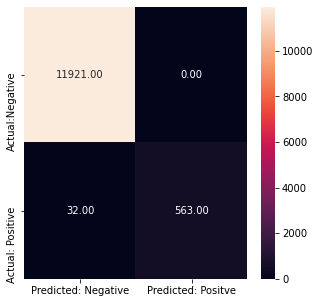

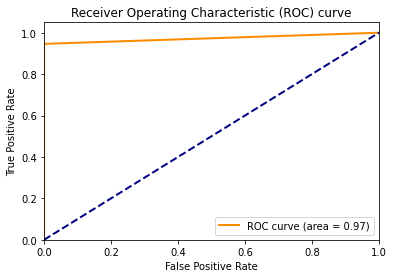

Classification report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      5093
         1.0       0.94      0.74      0.83       271

    accuracy                           0.98      5364
   macro avg       0.96      0.87      0.91      5364
weighted avg       0.98      0.98      0.98      5364

Confusion matrix:
[[5081   12]
 [  71  200]]


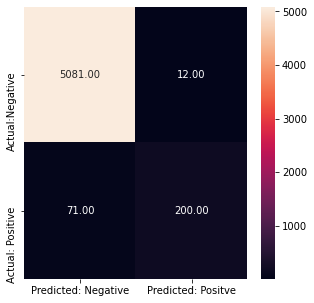

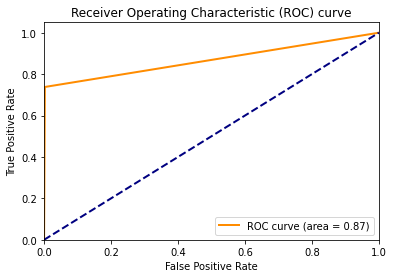

In [ ]:
y_train_pred=best_clf.predict(x_train)
y_test_pred=best_clf.predict(x_test)
evaluate(y_train, y_train_pred)
evaluate(y_test, y_test_pred)

In [ ]:
pd.DataFrame(searcher.cv_results_).sort_values('rank_test_score')[:10]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__C,param_clf__class_weight,param_vectorizer__max_features,param_vectorizer__ngram_range,param_vectorizer__stop_words,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
92,26.068604,2.431604,2.906213,0.280843,0.1,None,4000,"(1, 2)",None,"{'clf__C': 0.1, 'clf__class_weight': None, 've...",0.765714,0.753709,0.768786,0.762737,0.006505,1
187,20.392736,2.431579,1.836131,0.383652,0.5,None,4000,"(1, 1)",english,"{'clf__C': 0.5, 'clf__class_weight': None, 've...",0.790831,0.725714,0.764873,0.760473,0.026765,2
138,22.217666,0.724449,1.959648,0.455504,0.3,None,4000,"(1, 1)",None,"{'clf__C': 0.3, 'clf__class_weight': None, 've...",0.767908,0.741573,0.771831,0.760437,0.013435,3
188,31.696116,2.946375,3.360489,0.458099,0.5,None,4000,"(1, 2)",None,"{'clf__C': 0.5, 'clf__class_weight': None, 've...",0.785515,0.728814,0.765363,0.759897,0.023469,4
186,24.091464,1.410811,2.415237,0.429692,0.5,None,4000,"(1, 1)",None,"{'clf__C': 0.5, 'clf__class_weight': None, 've...",0.771429,0.738292,0.766667,0.758796,0.014628,5
140,29.412403,2.269211,3.414793,0.328695,0.3,None,4000,"(1, 2)",None,"{'clf__C': 0.3, 'clf__class_weight': None, 've...",0.779944,0.727794,0.767507,0.758415,0.022240,6
94,35.426023,1.656405,3.818437,0.190014,0.1,None,4000,"(1, 3)",None,"{'clf__C': 0.1, 'clf__class_weight': None, 've...",0.752137,0.756598,0.765217,0.757984,0.005429,7
142,41.903044,2.294497,4.632834,0.209555,0.3,None,4000,"(1, 3)",None,"{'clf__C': 0.3, 'clf__class_weight': None, 've...",0.769663,0.740947,0.762712,0.757774,0.012232,8
235,21.772292,1.353629,1.544776,0.082942,1,None,4000,"(1, 1)",english,"{'clf__C': 1, 'clf__class_weight': None, 'vect...",0.784314,0.715493,0.768362,0.756056,0.029413,9
139,19.220141,2.036566,2.017375,0.305972,0.3,None,4000,"(1, 1)",english,"{'clf__C': 0.3, 'clf__class_weight': None, 've...",0.779070,0.732558,0.754286,0.755305,0.019002,10


Tham số phù hợp:
- n_gram_range = (1,2)
- max_features >=4000
- C=0.1

(12516, 5000)
[[1 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  2.2min finished


Classification report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     11921
         1.0       1.00      0.95      0.97       595

    accuracy                           1.00     12516
   macro avg       1.00      0.97      0.99     12516
weighted avg       1.00      1.00      1.00     12516

Confusion matrix:
[[11921     0]
 [   30   565]]


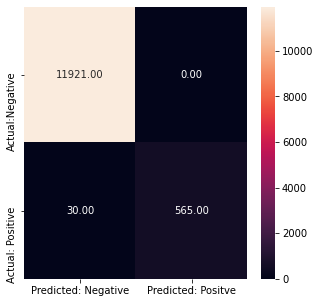

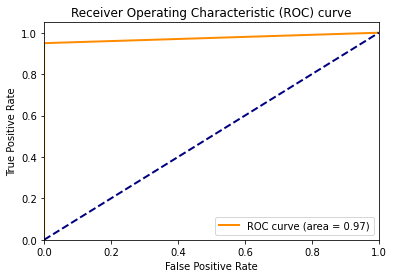

Classification report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      5093
         1.0       0.95      0.73      0.83       271

    accuracy                           0.98      5364
   macro avg       0.97      0.86      0.91      5364
weighted avg       0.98      0.98      0.98      5364

Confusion matrix:
[[5083   10]
 [  73  198]]


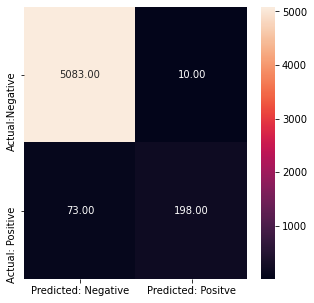

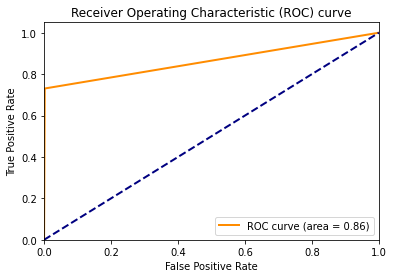

In [ ]:
vectorizer=vectorizer=CountVectorizer(lowercase=True, analyzer='word', stop_words= None, max_df=0.75,
                           max_features=5000, ngram_range=(1,2))
x_train_bin=vectorizer.fit_transform(x_train).todense()
x_test_bin=vectorizer.transform(x_test).todense()
print(x_train_bin.shape)
print(x_train_bin)

# clf=MultinomialNB()
clf=LogisticRegression(C=0.1, solver='lbfgs', max_iter=1000, verbose=10, n_jobs=-1)
clf.fit(x_train_bin, y_train)
y_train_pred=clf.predict(x_train_bin)
y_test_pred=clf.predict(x_test_bin)
evaluate(y_train, y_train_pred)
evaluate(y_test, y_test_pred)

# Train a model not base on text

In [ ]:
x_train, x_test, y_train, y_test=train_test_split(X, Y, test_size=0.3, random_state=42)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(12516, 38) (12516,) (5364, 38) (5364,)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   16.4s finished


Classification report:
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.98     11921
         1.0       0.60      0.04      0.08       595

    accuracy                           0.95     12516
   macro avg       0.77      0.52      0.53     12516
weighted avg       0.94      0.95      0.93     12516

Confusion matrix:
[[11904    17]
 [  570    25]]


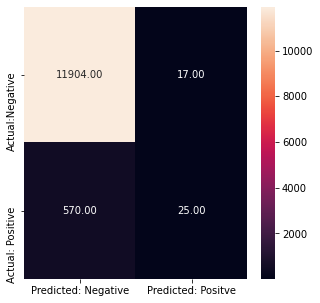

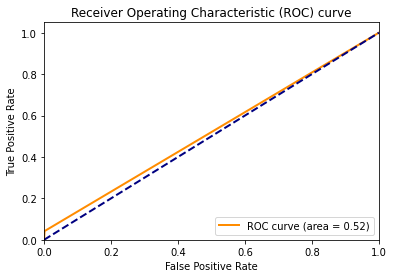

Classification report:
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97      5093
         1.0       0.67      0.04      0.07       271

    accuracy                           0.95      5364
   macro avg       0.81      0.52      0.52      5364
weighted avg       0.94      0.95      0.93      5364

Confusion matrix:
[[5088    5]
 [ 261   10]]


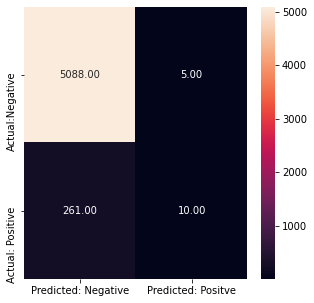

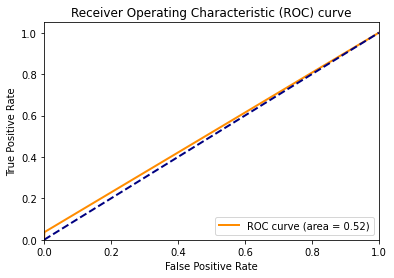

In [ ]:
clf=LogisticRegression(C=1, solver='lbfgs', max_iter=10000, verbose=10, n_jobs=-1)
clf.fit(x_train[:, 1:], y_train)
y_train_pred=clf.predict(x_train[:, 1:])
y_test_pred=clf.predict(x_test[:, 1:])
evaluate(y_train, y_train_pred)
evaluate(y_test, y_test_pred)

# Logistic Regression with all features

In [ ]:
vectorizer=vectorizer=CountVectorizer(lowercase=True, analyzer='word', stop_words= None, max_df=0.75,
                           max_features=4000, ngram_range=(1,2))
x_train_text_features=vectorizer.fit_transform(x_train[:, 0]).todense()
x_test_text_features=vectorizer.transform(x_test[:, 0]).todense()
print(x_train_text_features.shape)
print(x_train_text_features)

(12516, 4000)
[[1 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
# x_train_full=x_train_text_features
# x_test_full=x_test_text_features
# print(x_train_full)
x_train_full=np.concatenate([x_train_text_features, x_train[:, 1:]], axis=1)
x_test_full=np.concatenate([x_test_text_features, x_test[:, 1:]], axis=1)
scaler=StandardScaler()
x_train_full=scaler.fit_transform(x_train_full)
x_test_full=scaler.transform(x_test_full)
print(x_train_full.shape)
print(x_test_full.shape)

(12516, 4037)
(5364, 4037)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  2.0min finished


Classification report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     11926
         1.0       0.99      1.00      1.00       590

    accuracy                           1.00     12516
   macro avg       1.00      1.00      1.00     12516
weighted avg       1.00      1.00      1.00     12516

Confusion matrix:
[[11921     5]
 [    0   590]]


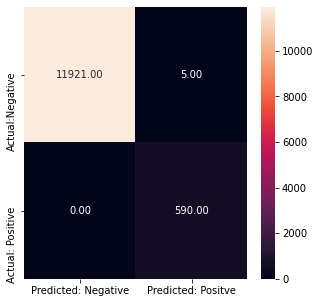

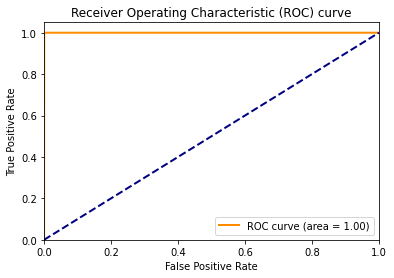

Classification report:
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      5149
         1.0       0.74      0.93      0.83       215

    accuracy                           0.98      5364
   macro avg       0.87      0.96      0.91      5364
weighted avg       0.99      0.98      0.99      5364

Confusion matrix:
[[5079   70]
 [  14  201]]


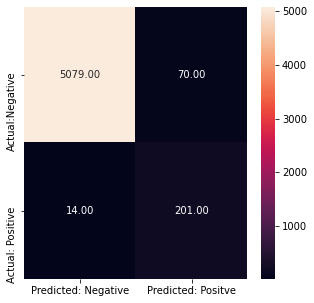

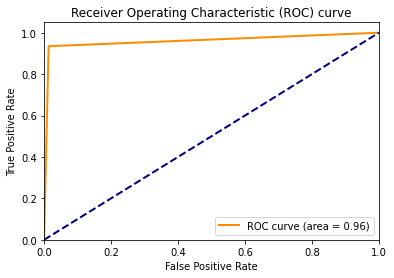

In [ ]:
# clf=MultinomialNB()
clf=LogisticRegression(C=0.1, solver='lbfgs', max_iter=1000, verbose=10, n_jobs=-1)
clf.fit(x_train_full, y_train)
y_train_pred=clf.predict(x_train_full)
y_test_pred=clf.predict(x_test_full)
evaluate(y_train_pred, y_train)
evaluate(y_test_pred, y_test)

# Multi-inputs model with all features

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Input, Concatenate
from keras import Model
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping
from keras import optimizers
from keras import backend as K
from keras.regularizers import l2
from keras.utils.vis_utils import plot_model

In [ ]:
def plot_learning_curve(history):
    sns.set(style='white',font_scale=1.3, rc={'figure.figsize':(6,6)})
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower right')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

In [ ]:
# callback functions on end of each epoch
reduce_lr=ReduceLROnPlateau(monitor='loss', factor=0.1, patience=20, verbose=1)
early_stop=EarlyStopping(monitor='loss', min_delta=1e-3, patience=40, restore_best_weights=True, verbose=1)

In [ ]:
def myModel(weight_decay=1e-2):
    # Input layer
    input1 = Input((37,))
    x1 = Dense(units=64, activation='relu', kernel_regularizer=l2(weight_decay))(input1)

    input2= Input((4000,))
    x2 = Dense(units=2048, activation='relu', kernel_regularizer=l2(weight_decay))(input2)
    x2 = Dense(units=256, activation='relu', kernel_regularizer=l2(weight_decay))(x2)

    combined= Concatenate()([x1, x2])
    # x = Dense(units=256, activation='relu', kernel_regularizer=l2(weight_decay))(combined)
    output = Dense(units=1, activation='sigmoid')(combined)
    model = Model(inputs=[input1, input2], outputs=output)
    return model

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_30 (InputLayer)           (None, 4000)         0                                            
__________________________________________________________________________________________________
input_29 (InputLayer)           (None, 37)           0                                            
__________________________________________________________________________________________________
dense_57 (Dense)                (None, 2048)         8194048     input_30[0][0]                   
__________________________________________________________________________________________________
dense_56 (Dense)                (None, 64)           2432        input_29[0][0]                   
___________________________________________________________________________________________

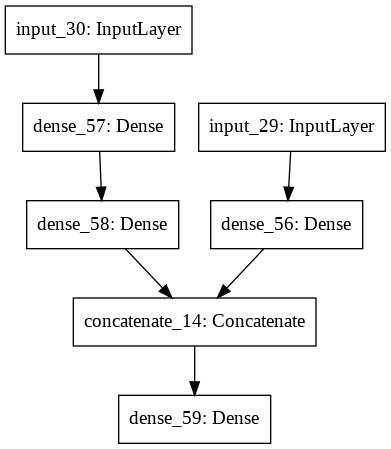

In [ ]:
model=myModel()
print(model.summary())
plot_model(model)

In [ ]:
# !mkdir checkpoints

### Model 1 (class_weight=2)

In [ ]:
BATCH_SIZE=4096
model_checkpoint=ModelCheckpoint(f'checkpoints/best_weights.hdf5', 
                             monitor='loss',save_best_only=True, save_weights_only=True)

model.compile(optimizer=optimizers.Adam(lr=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy'])
history=model.fit([x_train[:, 1:], x_train_text_features], y_train, shuffle=True, epochs=1000, workers=4,
                      batch_size=BATCH_SIZE, callbacks=[model_checkpoint, reduce_lr, early_stop], class_weight={0: 1, 1: 2})

Epoch 1/1000
12516/12516 [==============================] - 1s 49us/step - loss: 20.8855 - accuracy: 0.8986
Epoch 2/1000
12516/12516 [==============================] - 0s 32us/step - loss: 10.8133 - accuracy: 0.9507
Epoch 3/1000
12516/12516 [==============================] - 0s 32us/step - loss: 9.4366 - accuracy: 0.8669
Epoch 4/1000
12516/12516 [==============================] - 0s 31us/step - loss: 6.0610 - accuracy: 0.9496
Epoch 5/1000
12516/12516 [==============================] - 0s 31us/step - loss: 5.0335 - accuracy: 0.9040
Epoch 6/1000
12516/12516 [==============================] - 0s 31us/step - loss: 2.5295 - accuracy: 0.8963
Epoch 7/1000
12516/12516 [==============================] - 0s 31us/step - loss: 2.3782 - accuracy: 0.9187
Epoch 8/1000
12516/12516 [==============================] - 0s 31us/step - loss: 2.0742 - accuracy: 0.8790
Epoch 9/1000
12516/12516 [==============================] - 0s 30us/step - loss: 2.4321 - accuracy: 0.9557
Epoch 10/1000
12516/12516 [========

Classification report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     11921
         1.0       1.00      0.98      0.99       595

    accuracy                           1.00     12516
   macro avg       1.00      0.99      0.99     12516
weighted avg       1.00      1.00      1.00     12516

Confusion matrix:
[[11921     0]
 [   14   581]]


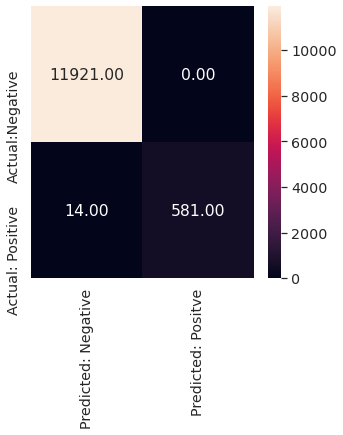

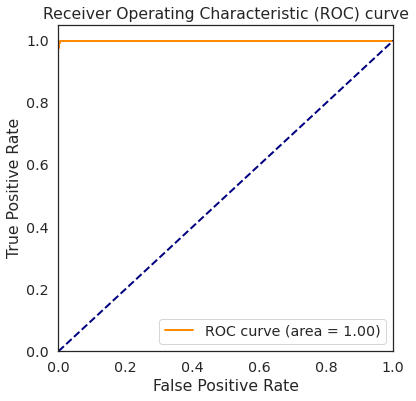

Classification report:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      5093
         1.0       0.89      0.81      0.85       271

    accuracy                           0.99      5364
   macro avg       0.94      0.90      0.92      5364
weighted avg       0.98      0.99      0.99      5364

Confusion matrix:
[[5067   26]
 [  52  219]]


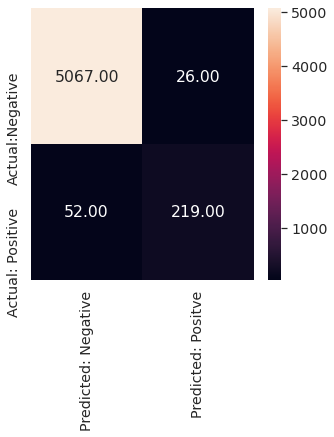

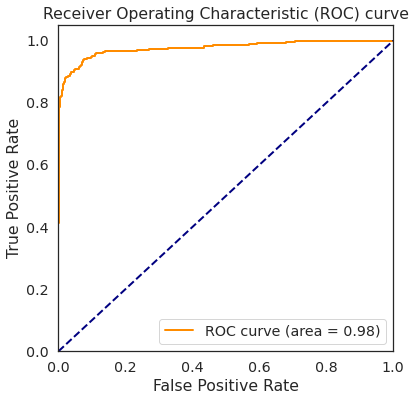

In [ ]:
y_train_pred=model.predict([x_train[:, 1:], x_train_text_features])
evaluate(y_train, y_train_pred)
y_test_pred=model.predict([x_test[:, 1:], x_test_text_features])
evaluate(y_test, y_test_pred)

### Model 2 (best-class_weight=5)

In [ ]:
BATCH_SIZE=4096
model_checkpoint=ModelCheckpoint(f'checkpoints/best_weights.hdf5', 
                             monitor='loss',save_best_only=True, save_weights_only=True)

model.compile(optimizer=optimizers.Adam(lr=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy'])
history=model.fit([x_train[:, 1:], x_train_text_features], y_train, shuffle=True, epochs=1000, workers=4,
                      batch_size=BATCH_SIZE, callbacks=[model_checkpoint, reduce_lr, early_stop], class_weight={0: 1, 1: 5})

Epoch 1/1000
12516/12516 [==============================] - 1s 42us/step - loss: 13.0702 - accuracy: 0.6815
Epoch 2/1000
12516/12516 [==============================] - 0s 29us/step - loss: 8.3648 - accuracy: 0.9525
Epoch 3/1000
12516/12516 [==============================] - 0s 29us/step - loss: 4.4955 - accuracy: 0.8405
Epoch 4/1000
12516/12516 [==============================] - 0s 28us/step - loss: 1.9014 - accuracy: 0.9173
Epoch 5/1000
12516/12516 [==============================] - 0s 29us/step - loss: 0.9578 - accuracy: 0.9585
Epoch 6/1000
12516/12516 [==============================] - 0s 28us/step - loss: 1.3098 - accuracy: 0.9692
Epoch 7/1000
12516/12516 [==============================] - 0s 29us/step - loss: 1.1131 - accuracy: 0.9538
Epoch 8/1000
12516/12516 [==============================] - 0s 29us/step - loss: 1.1584 - accuracy: 0.9747
Epoch 9/1000
12516/12516 [==============================] - 0s 29us/step - loss: 5.9685 - accuracy: 0.9057
Epoch 10/1000
12516/12516 [=========

Classification report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     11921
         1.0       1.00      1.00      1.00       595

    accuracy                           1.00     12516
   macro avg       1.00      1.00      1.00     12516
weighted avg       1.00      1.00      1.00     12516

Confusion matrix:
[[11919     2]
 [    1   594]]


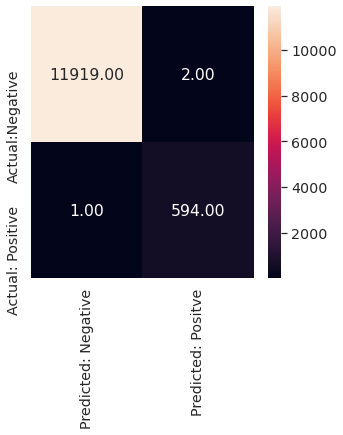

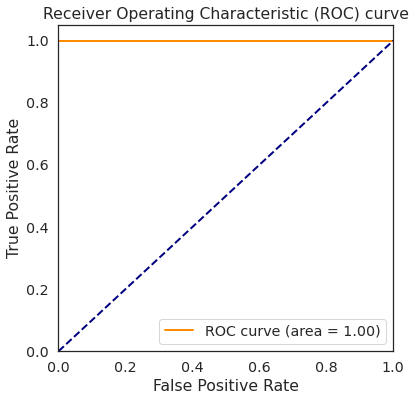

Classification report:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      5093
         1.0       0.87      0.83      0.85       271

    accuracy                           0.99      5364
   macro avg       0.93      0.91      0.92      5364
weighted avg       0.98      0.99      0.99      5364

Confusion matrix:
[[5060   33]
 [  46  225]]


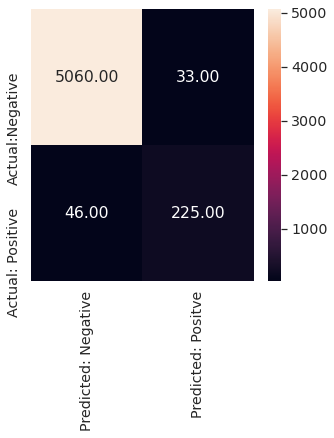

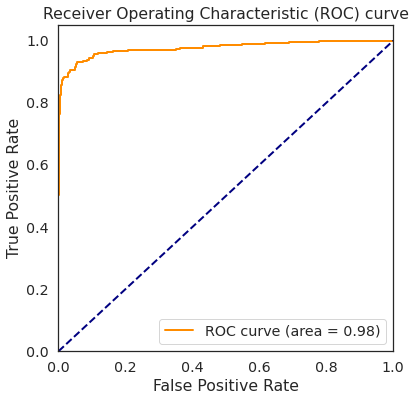

In [ ]:
y_train_pred=model.predict([x_train[:, 1:], x_train_text_features])
evaluate(y_train, y_train_pred)
y_test_pred=model.predict([x_test[:, 1:], x_test_text_features])
evaluate(y_test, y_test_pred)

### Model 3 (class_weight=10)

Epoch 1/1000
12516/12516 [==============================] - 1s 43us/step - loss: 14.3491 - accuracy: 0.6865
Epoch 2/1000
12516/12516 [==============================] - 0s 30us/step - loss: 4.9874 - accuracy: 0.7254
Epoch 3/1000
12516/12516 [==============================] - 0s 30us/step - loss: 5.9667 - accuracy: 0.9088
Epoch 4/1000
12516/12516 [==============================] - 0s 29us/step - loss: 2.7192 - accuracy: 0.9297
Epoch 5/1000
12516/12516 [==============================] - 0s 30us/step - loss: 2.6399 - accuracy: 0.9669
Epoch 6/1000
12516/12516 [==============================] - 0s 31us/step - loss: 2.7692 - accuracy: 0.9675
Epoch 7/1000
12516/12516 [==============================] - 0s 30us/step - loss: 2.8870 - accuracy: 0.9513
Epoch 8/1000
12516/12516 [==============================] - 0s 30us/step - loss: 2.7453 - accuracy: 0.9781
Epoch 9/1000
12516/12516 [==============================] - 0s 29us/step - loss: 2.9214 - accuracy: 0.9675
Epoch 10/1000
12516/12516 [=========

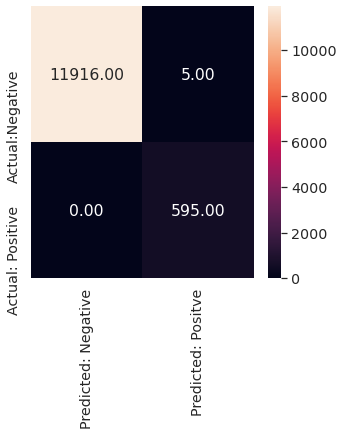

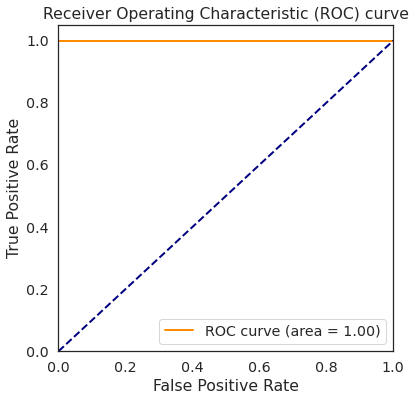

Classification report:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      5093
         1.0       0.81      0.84      0.83       271

    accuracy                           0.98      5364
   macro avg       0.90      0.92      0.91      5364
weighted avg       0.98      0.98      0.98      5364

Confusion matrix:
[[5040   53]
 [  43  228]]


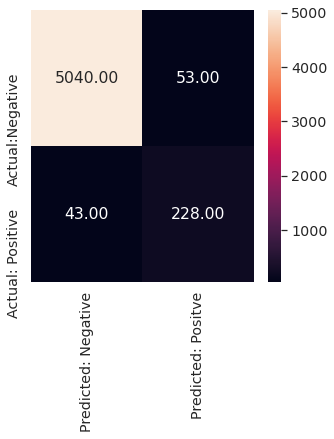

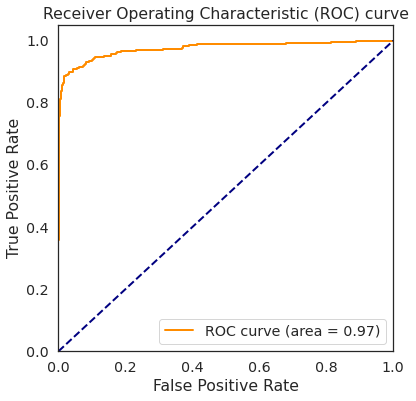

In [ ]:
BATCH_SIZE=4096
model_checkpoint=ModelCheckpoint(f'checkpoints/best_weights.hdf5', 
                             monitor='loss',save_best_only=True, save_weights_only=True)

model.compile(optimizer=optimizers.Adam(lr=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy'])
history=model.fit([x_train[:, 1:], x_train_text_features], y_train, shuffle=True, epochs=1000, workers=4,
                      batch_size=BATCH_SIZE, callbacks=[model_checkpoint, reduce_lr, early_stop], class_weight={0: 1, 1: 10})

y_train_pred=model.predict([x_train[:, 1:], x_train_text_features])
evaluate(y_train, y_train_pred)
y_test_pred=model.predict([x_test[:, 1:], x_test_text_features])
evaluate(y_test, y_test_pred)